In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras

Download the model:

```
wget https://github.com/alexeygrigorev/mlbookcamp-code/releases/download/chapter7-model/xception_v4_large_08_0.894.h5
```

In [2]:
model = keras.models.load_model('xception_v4_large_08_0.894.h5')

## Testing the model

In [3]:
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import load_img 

In [4]:
labels = [
    'dress',
    'hat',
    'longsleeve',
    'outwear',
    'pants',
    'shirt',
    'shoes',
    'shorts',
    'skirt',
    't-shirt'
]

In [5]:
!wget https://raw.githubusercontent.com/alexeygrigorev/clothing-dataset-small/master/test/pants/4aabd82c-82e1-4181-a84d-d0c6e550d26d.jpg -O pants.jpg

--2020-11-12 17:52:54--  https://raw.githubusercontent.com/alexeygrigorev/clothing-dataset-small/master/test/pants/4aabd82c-82e1-4181-a84d-d0c6e550d26d.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23048 (23K) [image/jpeg]
Saving to: ‘pants.jpg’

pants.jpg           100%[===================>]  22,51K  --.-KB/s    in 0,009s  

2020-11-12 17:52:55 (2,50 MB/s) - ‘pants.jpg’ saved [23048/23048]



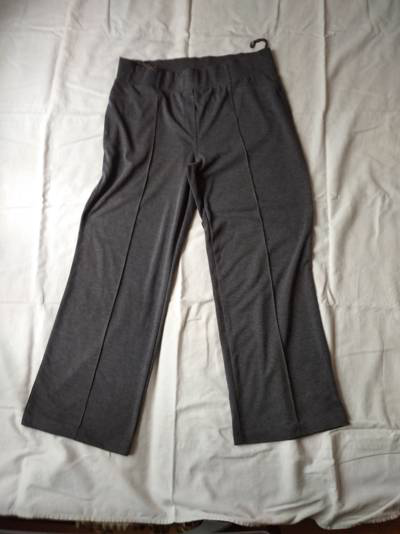

In [6]:
load_img('pants.jpg')

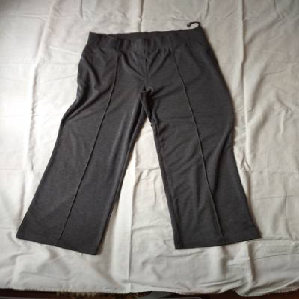

In [7]:
load_img('pants.jpg', target_size=(299, 299))

In [8]:
img = load_img('pants.jpg', target_size=(299, 299))

In [9]:
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)

In [10]:
preds = model.predict(X)
preds[0]

array([-1.8682908, -4.761245 , -2.3169835, -1.0625703,  9.887161 ,
       -2.812434 , -3.6662831,  3.2003617, -2.6023383, -4.835047 ],
      dtype=float32)

In [11]:
dict(zip(labels, preds[0]))

{'dress': -1.8682908,
 'hat': -4.761245,
 'longsleeve': -2.3169835,
 'outwear': -1.0625703,
 'pants': 9.887161,
 'shirt': -2.812434,
 'shoes': -3.6662831,
 'shorts': 3.2003617,
 'skirt': -2.6023383,
 't-shirt': -4.835047}

## Coverting the model

In [12]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [13]:
tflite_model = converter.convert()

with tf.io.gfile.GFile('clothing-model-v4.tflite', 'wb') as f:
    f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpqgdg9jzp/assets


In [14]:
!ls -lh xception_v4_large_08_0.894.h5 clothing-model-v4.tflite

-rw-r--r-- 1 alexeygrigorev alexeygrigorev 81M Nov 12 17:54 clothing-model-v4.tflite
-rw-r--r-- 1 alexeygrigorev alexeygrigorev 83M Sep 26 22:38 xception_v4_large_08_0.894.h5


## Using the model

In [15]:
import tensorflow.lite as tflite
# in lambda, we'll need to use this import
# import tflite_runtime.interpreter as tflite 

In [16]:
interpreter = tflite.Interpreter(model_path='clothing-model-v4.tflite')
interpreter.allocate_tensors()

In [17]:
input_details = interpreter.get_input_details()
input_index = input_details[0]['index']

output_details = interpreter.get_output_details()
output_index = output_details[0]['index']

In [18]:
interpreter.set_tensor(input_index, X)
interpreter.invoke()

preds = interpreter.get_tensor(output_index)

In [19]:
dict(zip(labels, preds[0]))

{'dress': -1.8682897,
 'hat': -4.7612453,
 'longsleeve': -2.316984,
 'outwear': -1.0625705,
 'pants': 9.887156,
 'shirt': -2.8124316,
 'shoes': -3.6662838,
 'shorts': 3.2003622,
 'skirt': -2.6023388,
 't-shirt': -4.8350453}

## Pre-processing functions

We can't take Keras-preprocessing with us (too heavy). So let's take only things we need

In [20]:
from io import BytesIO
from urllib import request

import numpy as np
from PIL import Image

In [21]:
def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img

def prepare_image(img, target_size=(224, 224)):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, Image.NEAREST)
    return img

In [22]:
def image_to_array(img):
    return np.array(img, dtype='float32')

def tf_preprocessing(x):
    x /= 127.5
    x -= 1.0
    return x

def convert_to_tensor(img):
    x = image_to_array(img)
    batch = np.expand_dims(x, axis=0)
    return tf_preprocessing(batch)

Note: some models (resnet, VGG) need Caffe preprocessing:

```python
mean = [103.939, 116.779, 123.68]

def caffe_preprocessing(x):
    # 'RGB'->'BGR'
    x = x[..., ::-1]

    x[..., 0] -= mean[0]
    x[..., 1] -= mean[1]
    x[..., 2] -= mean[2]

    return x
```

Do it once on startup

In [23]:
interpreter = tflite.Interpreter(model_path='clothing-model-v4.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
input_index = input_details[0]['index']

output_details = interpreter.get_output_details()
output_index = output_details[0]['index']

Use for predictions

In [24]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/clothing-dataset-small/master/test/pants/4aabd82c-82e1-4181-a84d-d0c6e550d26d.jpg'

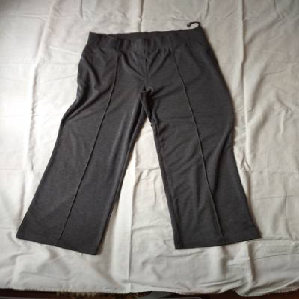

In [25]:
img = download_image(url)
img = prepare_image(img, target_size=(299, 299))
img

In [26]:
X = convert_to_tensor(img)

In [27]:
interpreter.set_tensor(input_index, X)
interpreter.invoke()

preds = interpreter.get_tensor(output_index)

In [28]:
dict(zip(labels, preds[0]))

{'dress': -1.8682897,
 'hat': -4.7612453,
 'longsleeve': -2.316984,
 'outwear': -1.0625705,
 'pants': 9.887156,
 'shirt': -2.8124316,
 'shoes': -3.6662838,
 'shorts': 3.2003622,
 'skirt': -2.6023388,
 't-shirt': -4.8350453}

In [29]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/clothing-dataset-small/master/test/shoes/ab3238c6-2607-4850-8a17-3e9027867a6c.jpg'

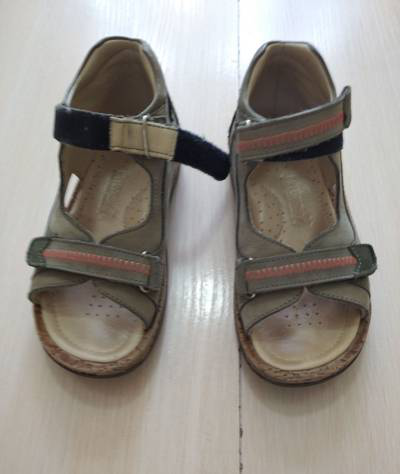

In [30]:
download_image(url)

In [31]:
img = download_image(url)
img = prepare_image(img, target_size=(299, 299))
X = convert_to_tensor(img)

interpreter.set_tensor(input_index, X)
interpreter.invoke()

preds = interpreter.get_tensor(output_index)
dict(zip(labels, preds[0]))

{'dress': -2.353972,
 'hat': 0.48841903,
 'longsleeve': -5.0832467,
 'outwear': -0.22363108,
 'pants': -1.688745,
 'shirt': -1.4102441,
 'shoes': 10.446299,
 'shorts': -2.2525518,
 'skirt': -2.1975071,
 't-shirt': -3.720522}

^^ this is what will go to the lambda function